# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [ ]:
# run this once to unzip the file
!unzip processed-celeba-small.zip

In [1]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
import os

from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, transforms

import tests

In [2]:
data_dir = 'processed_celeba_small/celeba/'
train_on_gpu = torch.cuda.is_available()

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [3]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms_list = [transforms.Resize(64),
                  ToTensor(),
                  transforms.Normalize((0.5,), (0.5,))]
    
    return Compose(transforms_list)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [4]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = get_transforms((64,64)), 
                 extension: str = '.jpg'):
        self.img_paths = glob(os.path.join(directory, '*' + extension))
        self.img_dir = directory
        self.transforms = transforms

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        return len(self.img_paths)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        img_path = self.img_paths[index]
        image = Image.open(img_path)
        return self.transforms(image)

In [5]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

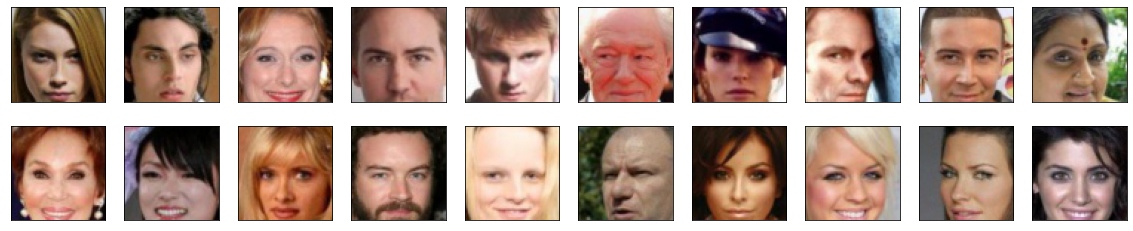

In [6]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [7]:
from torch.nn import Module
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, batch_norm: bool = True):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [9]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
      # complete init function
        conv_dim = 64

        # 32x32 input
        self.conv1 = ConvBlock(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.lr1 = nn.LeakyReLU(0.2)
        self.conv2 = ConvBlock(conv_dim, conv_dim*2, 4)
        self.lr2 = nn.LeakyReLU(0.2)
        # 8x8 out
        self.conv3 = ConvBlock(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        self.lr3 = nn.LeakyReLU(0.2)
        
        self.flatten = nn.Flatten()
        # final, fully-connected layer
        self.fc1 = nn.Linear(conv_dim*8*8*4, conv_dim*4)
        
        self.leaky_relu1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(conv_dim*4,1)
        
    def forward(self, x):
        # all hidden layers + leaky relu activation
        x = self.conv1(x)
        x = self.lr1(x)
        x = self.conv2(x)
        x = self.lr2(x)
        x = self.conv3(x)
        x = self.lr3(x)
        # flatten
        x = self.flatten(x)
        # final output layer
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.fc2(x)
        return x.view(-1,1,1,1)

In [10]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [11]:
class DeconvBlock(nn.Module):
    """
    A "de-convolutional" block is made of 3 layers: ConvTranspose -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - stride: stride of the conv layer
    - padding: padding of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int,
                 padding: int,
                 batch_norm: bool = True):
        super(DeconvBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.deconv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [12]:
class Generator(nn.Module):
    """
    The generator model adapted from DCGAN
    args:
    - latent_dim: dimension of the latent vector
    - conv_dim: control the number of filters in the convtranspose layers
    """
    def __init__(self, latent_dim: int, conv_dim: int = 64):
        super(Generator, self).__init__()
        # transpose conv layers
        self.deconv1 = DeconvBlock(latent_dim, conv_dim*8, 4, 1, 0)
        self.deconv2 = DeconvBlock(conv_dim*8, conv_dim*4, 4, 2, 1)
        self.deconv3 = DeconvBlock(conv_dim*4, conv_dim*2, 4, 2, 1)
        self.deconv4 = DeconvBlock(conv_dim*2, conv_dim, 4, 2, 1)
        self.deconv5 = nn.ConvTranspose2d(conv_dim, 3, 4, stride=2, padding=1)
        self.last_activation = nn.Tanh()
        
    def forward(self, x):
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)
        x = self.last_activation(x)
        return x

In [13]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [14]:
import torch.optim as optim

def create_optimizers(generator: Module, discriminator: Module):
    # params
    lr = 0.0002
    beta1 = 0.5
    beta2 = 0.999
    
    g_optimizer = optim.Adam(generator.parameters(),lr,[beta1,beta2])
    d_optimizer = optim.Adam(discriminator.parameters(),lr,[beta1,beta2])
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [15]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [16]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
    
    return real_loss(fake_logits)

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [17]:

def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # TODO: implement the discriminator loss 
    return real_loss(real_logits) + fake_loss(fake_logits)

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [18]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    gp = 0
    # TODO (Optional): implement the gradient penalty
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [19]:
def generator_step(batch_size: int, latent_dim: int,gmodel: nn.Module,dmodel: nn.Module) -> Dict:
    """ One training step of the generator. """

    z_size = 128
    """ One training step of the generator. """

    g_optimizer.zero_grad()
        
    #Train with fake images and flipped labels
        
    # Generate fake images
    z = np.random.uniform(-1, 1, size=(batch_size, z_size, 1, 1))
    z = torch.from_numpy(z).float()
    if train_on_gpu:
        z = z.cuda()
    fake_images = gmodel(z)
        
    # Compute the discriminator losses on fake images 
    # using flipped labels!
    D_fake = dmodel(fake_images)
    g_loss = real_loss(D_fake) # use real loss to flip labels
        
    # perform backprop
    g_loss.backward()
    g_optimizer.step()
    
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor,gmodel: nn.Module,dmodel: nn.Module) -> Dict:
    """ One training step of the discriminator. """

    z_size = 128
    batch_size = real_images.size(0)
    
    d_optimizer.zero_grad()
        
    # 1. Train with real images

    # Compute the discriminator losses on real images 
    if train_on_gpu:
        real_images = real_images.cuda()
        
    D_real = dmodel(real_images)
    #d_real_loss = real_loss(D_real)  
    
    # 2. Train with fake images
        
    # Generate fake images
    z = np.random.uniform(-1, 1, size=(batch_size, z_size, 1, 1))
    z = torch.from_numpy(z).float()
    # move x to GPU, if available
    if train_on_gpu:
        z = z.cuda()
    fake_images = gmodel(z)
    
    # Compute the discriminator losses on fake images            
    D_fake = dmodel(fake_images.detach())
    #d_fake_loss = fake_loss(D_fake)
    
    # add up loss and perform backprop
    d_loss = discriminator_loss(D_real,D_fake)
    
    d_loss.backward()
    d_optimizer.step()
    
    gp = 0

    #return {'loss': d_loss, 'gp': gp}
    return d_loss

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [20]:
from datetime import datetime


In [21]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 20

# number of images in each batch
batch_size = 64

In [22]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
if train_on_gpu:
    generator = Generator(latent_dim).to(device)
    discriminator = Discriminator().to(device)
else:
    generator = Generator(latent_dim)
    discriminator = Discriminator()

g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

train_on_gpu = torch.cuda.is_available()

# move models to GPU
if train_on_gpu:
    
    generator.cuda()
    discriminator.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')

GPU available for training. Models moved to GPU


In [23]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2024-05-10 12:11:46 | Epoch [1/20] | Batch 0/509 | d_loss: 1.4613 | g_loss: 0.5520
2024-05-10 12:11:53 | Epoch [1/20] | Batch 50/509 | d_loss: 1.0941 | g_loss: 1.8811
2024-05-10 12:11:59 | Epoch [1/20] | Batch 100/509 | d_loss: 1.0151 | g_loss: 2.8202
2024-05-10 12:12:05 | Epoch [1/20] | Batch 150/509 | d_loss: 0.5145 | g_loss: 3.2902
2024-05-10 12:12:12 | Epoch [1/20] | Batch 200/509 | d_loss: 2.0317 | g_loss: 2.7628
2024-05-10 12:12:18 | Epoch [1/20] | Batch 250/509 | d_loss: 1.6467 | g_loss: 1.8082
2024-05-10 12:12:24 | Epoch [1/20] | Batch 300/509 | d_loss: 1.1077 | g_loss: 0.8716
2024-05-10 12:12:31 | Epoch [1/20] | Batch 350/509 | d_loss: 1.2712 | g_loss: 1.1624
2024-05-10 12:12:37 | Epoch [1/20] | Batch 400/509 | d_loss: 1.1871 | g_loss: 0.7762
2024-05-10 12:12:44 | Epoch [1/20] | Batch 450/509 | d_loss: 1.2684 | g_loss: 0.4364
2024-05-10 12:12:50 | Epoch [1/20] | Batch 500/509 | d_loss: 1.2945 | g_loss: 1.3568


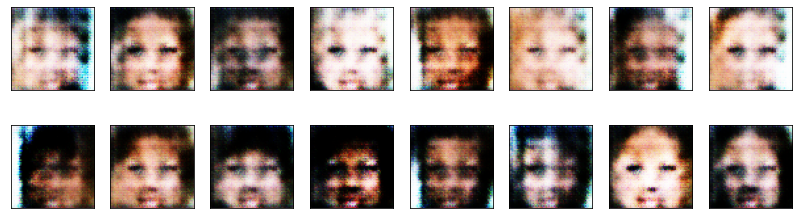

2024-05-10 12:12:55 | Epoch [2/20] | Batch 0/509 | d_loss: 1.3031 | g_loss: 1.2091
2024-05-10 12:13:02 | Epoch [2/20] | Batch 50/509 | d_loss: 1.3940 | g_loss: 0.9367
2024-05-10 12:13:09 | Epoch [2/20] | Batch 100/509 | d_loss: 1.1585 | g_loss: 1.0658
2024-05-10 12:13:15 | Epoch [2/20] | Batch 150/509 | d_loss: 1.3871 | g_loss: 0.7562
2024-05-10 12:13:22 | Epoch [2/20] | Batch 200/509 | d_loss: 1.2847 | g_loss: 1.8651
2024-05-10 12:13:29 | Epoch [2/20] | Batch 250/509 | d_loss: 1.1664 | g_loss: 1.6808
2024-05-10 12:13:35 | Epoch [2/20] | Batch 300/509 | d_loss: 1.6955 | g_loss: 2.7138
2024-05-10 12:13:42 | Epoch [2/20] | Batch 350/509 | d_loss: 1.3710 | g_loss: 1.6186
2024-05-10 12:13:49 | Epoch [2/20] | Batch 400/509 | d_loss: 1.1771 | g_loss: 1.3086
2024-05-10 12:13:55 | Epoch [2/20] | Batch 450/509 | d_loss: 1.3999 | g_loss: 0.3062
2024-05-10 12:14:02 | Epoch [2/20] | Batch 500/509 | d_loss: 1.1708 | g_loss: 1.1786


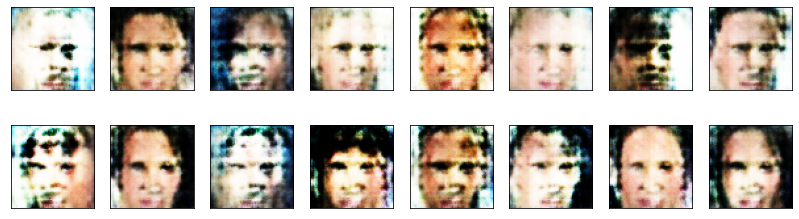

2024-05-10 12:14:06 | Epoch [3/20] | Batch 0/509 | d_loss: 1.2753 | g_loss: 1.0893
2024-05-10 12:14:13 | Epoch [3/20] | Batch 50/509 | d_loss: 1.3523 | g_loss: 1.0786
2024-05-10 12:14:20 | Epoch [3/20] | Batch 100/509 | d_loss: 1.2961 | g_loss: 1.0253
2024-05-10 12:14:26 | Epoch [3/20] | Batch 150/509 | d_loss: 1.4199 | g_loss: 1.2104
2024-05-10 12:14:33 | Epoch [3/20] | Batch 200/509 | d_loss: 1.1700 | g_loss: 1.1997
2024-05-10 12:14:40 | Epoch [3/20] | Batch 250/509 | d_loss: 1.1714 | g_loss: 1.0801
2024-05-10 12:14:46 | Epoch [3/20] | Batch 300/509 | d_loss: 1.3800 | g_loss: 0.7378
2024-05-10 12:14:53 | Epoch [3/20] | Batch 350/509 | d_loss: 1.2058 | g_loss: 1.1061
2024-05-10 12:15:00 | Epoch [3/20] | Batch 400/509 | d_loss: 1.1157 | g_loss: 1.1392
2024-05-10 12:15:06 | Epoch [3/20] | Batch 450/509 | d_loss: 1.1660 | g_loss: 1.2755
2024-05-10 12:15:13 | Epoch [3/20] | Batch 500/509 | d_loss: 1.0657 | g_loss: 0.9771


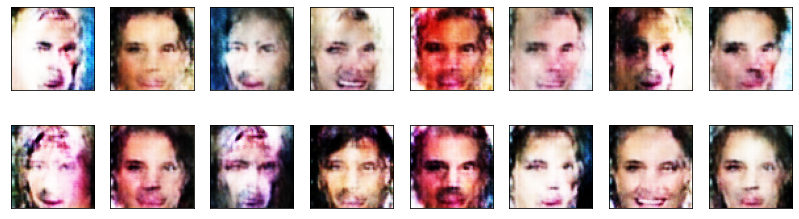

2024-05-10 12:15:19 | Epoch [4/20] | Batch 0/509 | d_loss: 1.2509 | g_loss: 1.3553
2024-05-10 12:15:26 | Epoch [4/20] | Batch 50/509 | d_loss: 1.1546 | g_loss: 1.2258
2024-05-10 12:15:33 | Epoch [4/20] | Batch 100/509 | d_loss: 1.1620 | g_loss: 1.2128
2024-05-10 12:15:39 | Epoch [4/20] | Batch 150/509 | d_loss: 1.0625 | g_loss: 0.9071
2024-05-10 12:15:46 | Epoch [4/20] | Batch 200/509 | d_loss: 1.0807 | g_loss: 0.8347
2024-05-10 12:15:53 | Epoch [4/20] | Batch 250/509 | d_loss: 1.1181 | g_loss: 1.1535
2024-05-10 12:15:59 | Epoch [4/20] | Batch 300/509 | d_loss: 2.2999 | g_loss: 0.5657
2024-05-10 12:16:06 | Epoch [4/20] | Batch 350/509 | d_loss: 1.0304 | g_loss: 1.3866
2024-05-10 12:16:13 | Epoch [4/20] | Batch 400/509 | d_loss: 1.0379 | g_loss: 1.4647
2024-05-10 12:16:19 | Epoch [4/20] | Batch 450/509 | d_loss: 0.9650 | g_loss: 1.6221
2024-05-10 12:16:26 | Epoch [4/20] | Batch 500/509 | d_loss: 0.9867 | g_loss: 1.3508


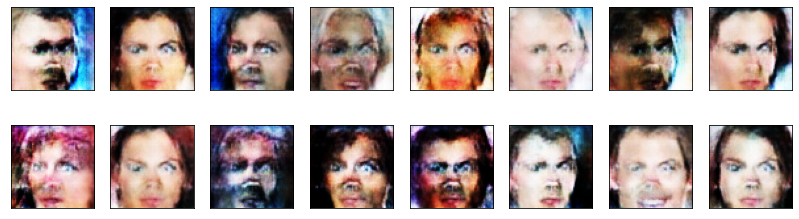

2024-05-10 12:16:32 | Epoch [5/20] | Batch 0/509 | d_loss: 0.9423 | g_loss: 1.1736
2024-05-10 12:16:38 | Epoch [5/20] | Batch 50/509 | d_loss: 1.0758 | g_loss: 1.1125
2024-05-10 12:16:45 | Epoch [5/20] | Batch 100/509 | d_loss: 0.9116 | g_loss: 1.0057
2024-05-10 12:16:52 | Epoch [5/20] | Batch 150/509 | d_loss: 1.1138 | g_loss: 1.0827
2024-05-10 12:16:58 | Epoch [5/20] | Batch 200/509 | d_loss: 0.9864 | g_loss: 1.3285
2024-05-10 12:17:05 | Epoch [5/20] | Batch 250/509 | d_loss: 1.2171 | g_loss: 2.0418
2024-05-10 12:17:12 | Epoch [5/20] | Batch 300/509 | d_loss: 0.9018 | g_loss: 1.1034
2024-05-10 12:17:18 | Epoch [5/20] | Batch 350/509 | d_loss: 2.1902 | g_loss: 1.4109
2024-05-10 12:17:25 | Epoch [5/20] | Batch 400/509 | d_loss: 1.0510 | g_loss: 1.2398
2024-05-10 12:17:32 | Epoch [5/20] | Batch 450/509 | d_loss: 1.0500 | g_loss: 1.2957
2024-05-10 12:17:38 | Epoch [5/20] | Batch 500/509 | d_loss: 1.2622 | g_loss: 1.9642


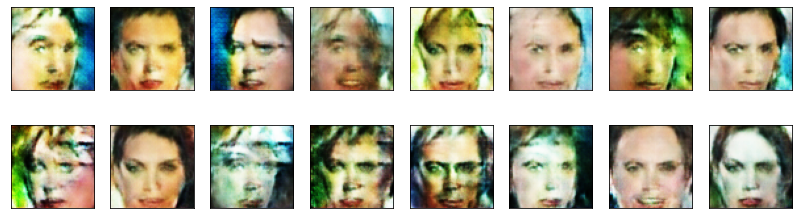

2024-05-10 12:17:43 | Epoch [6/20] | Batch 0/509 | d_loss: 1.0181 | g_loss: 1.7889
2024-05-10 12:17:50 | Epoch [6/20] | Batch 50/509 | d_loss: 1.2974 | g_loss: 2.8807
2024-05-10 12:17:56 | Epoch [6/20] | Batch 100/509 | d_loss: 0.8808 | g_loss: 1.3963
2024-05-10 12:18:03 | Epoch [6/20] | Batch 150/509 | d_loss: 1.0858 | g_loss: 1.6007
2024-05-10 12:18:10 | Epoch [6/20] | Batch 200/509 | d_loss: 0.8641 | g_loss: 1.2726
2024-05-10 12:18:16 | Epoch [6/20] | Batch 250/509 | d_loss: 0.9155 | g_loss: 1.7571
2024-05-10 12:18:23 | Epoch [6/20] | Batch 300/509 | d_loss: 1.1415 | g_loss: 1.4708
2024-05-10 12:18:30 | Epoch [6/20] | Batch 350/509 | d_loss: 1.0715 | g_loss: 1.0148
2024-05-10 12:18:37 | Epoch [6/20] | Batch 400/509 | d_loss: 1.1416 | g_loss: 1.7943
2024-05-10 12:18:43 | Epoch [6/20] | Batch 450/509 | d_loss: 1.0457 | g_loss: 1.6739
2024-05-10 12:18:50 | Epoch [6/20] | Batch 500/509 | d_loss: 1.0951 | g_loss: 1.7001


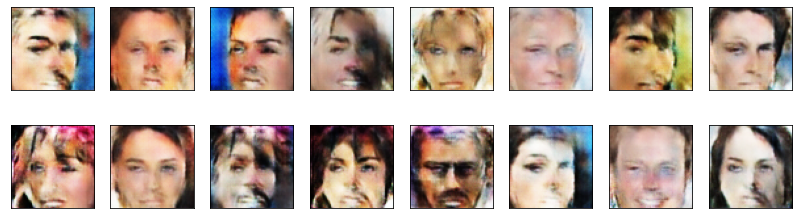

2024-05-10 12:18:55 | Epoch [7/20] | Batch 0/509 | d_loss: 0.8858 | g_loss: 1.5622
2024-05-10 12:19:02 | Epoch [7/20] | Batch 50/509 | d_loss: 0.9491 | g_loss: 2.3940
2024-05-10 12:19:09 | Epoch [7/20] | Batch 100/509 | d_loss: 0.8949 | g_loss: 1.1307
2024-05-10 12:19:15 | Epoch [7/20] | Batch 150/509 | d_loss: 0.8424 | g_loss: 1.7115
2024-05-10 12:19:22 | Epoch [7/20] | Batch 200/509 | d_loss: 1.1484 | g_loss: 0.3826
2024-05-10 12:19:29 | Epoch [7/20] | Batch 250/509 | d_loss: 1.0891 | g_loss: 1.7808
2024-05-10 12:19:35 | Epoch [7/20] | Batch 300/509 | d_loss: 1.1457 | g_loss: 2.1663
2024-05-10 12:19:42 | Epoch [7/20] | Batch 350/509 | d_loss: 0.9151 | g_loss: 1.8080
2024-05-10 12:19:49 | Epoch [7/20] | Batch 400/509 | d_loss: 1.0739 | g_loss: 2.0303
2024-05-10 12:19:55 | Epoch [7/20] | Batch 450/509 | d_loss: 0.9270 | g_loss: 2.3772
2024-05-10 12:20:02 | Epoch [7/20] | Batch 500/509 | d_loss: 0.9527 | g_loss: 1.3385


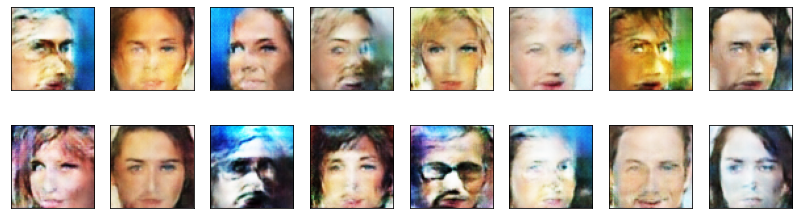

2024-05-10 12:20:07 | Epoch [8/20] | Batch 0/509 | d_loss: 0.8972 | g_loss: 1.2426
2024-05-10 12:20:13 | Epoch [8/20] | Batch 50/509 | d_loss: 1.0560 | g_loss: 1.2474
2024-05-10 12:20:20 | Epoch [8/20] | Batch 100/509 | d_loss: 0.6804 | g_loss: 1.2190
2024-05-10 12:20:27 | Epoch [8/20] | Batch 150/509 | d_loss: 0.8165 | g_loss: 2.3468
2024-05-10 12:20:33 | Epoch [8/20] | Batch 200/509 | d_loss: 0.9568 | g_loss: 1.9046
2024-05-10 12:20:40 | Epoch [8/20] | Batch 250/509 | d_loss: 1.0639 | g_loss: 2.6462
2024-05-10 12:20:47 | Epoch [8/20] | Batch 300/509 | d_loss: 1.3085 | g_loss: 3.1217
2024-05-10 12:20:53 | Epoch [8/20] | Batch 350/509 | d_loss: 1.0655 | g_loss: 1.6705
2024-05-10 12:21:00 | Epoch [8/20] | Batch 400/509 | d_loss: 0.9602 | g_loss: 1.2959
2024-05-10 12:21:07 | Epoch [8/20] | Batch 450/509 | d_loss: 1.1093 | g_loss: 1.0400
2024-05-10 12:21:13 | Epoch [8/20] | Batch 500/509 | d_loss: 0.6111 | g_loss: 1.2567


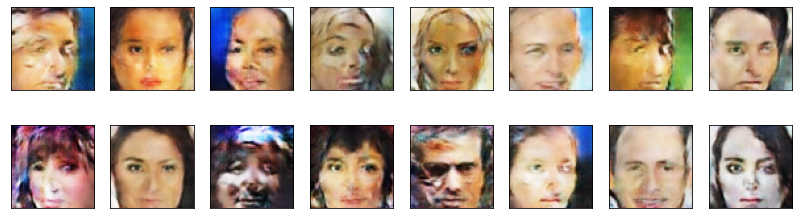

2024-05-10 12:21:18 | Epoch [9/20] | Batch 0/509 | d_loss: 1.0613 | g_loss: 1.0951
2024-05-10 12:21:25 | Epoch [9/20] | Batch 50/509 | d_loss: 1.3853 | g_loss: 2.9963
2024-05-10 12:21:31 | Epoch [9/20] | Batch 100/509 | d_loss: 0.9002 | g_loss: 2.0468
2024-05-10 12:21:38 | Epoch [9/20] | Batch 150/509 | d_loss: 1.0367 | g_loss: 1.9715
2024-05-10 12:21:45 | Epoch [9/20] | Batch 200/509 | d_loss: 1.3478 | g_loss: 2.1212
2024-05-10 12:21:51 | Epoch [9/20] | Batch 250/509 | d_loss: 1.3000 | g_loss: 3.2575
2024-05-10 12:21:58 | Epoch [9/20] | Batch 300/509 | d_loss: 1.2629 | g_loss: 0.8819
2024-05-10 12:22:05 | Epoch [9/20] | Batch 350/509 | d_loss: 1.1614 | g_loss: 2.5316
2024-05-10 12:22:11 | Epoch [9/20] | Batch 400/509 | d_loss: 0.9651 | g_loss: 2.1657
2024-05-10 12:22:18 | Epoch [9/20] | Batch 450/509 | d_loss: 0.7599 | g_loss: 1.4005
2024-05-10 12:22:25 | Epoch [9/20] | Batch 500/509 | d_loss: 1.0575 | g_loss: 1.9878


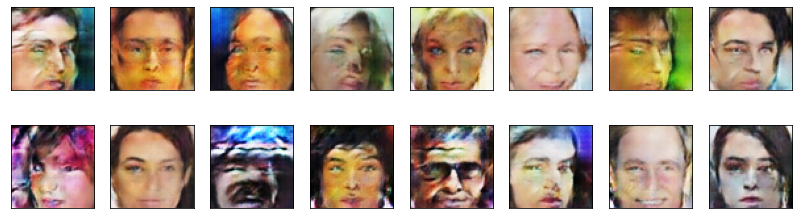

2024-05-10 12:22:30 | Epoch [10/20] | Batch 0/509 | d_loss: 1.2034 | g_loss: 1.8368
2024-05-10 12:22:37 | Epoch [10/20] | Batch 50/509 | d_loss: 1.2220 | g_loss: 1.1284
2024-05-10 12:22:44 | Epoch [10/20] | Batch 100/509 | d_loss: 0.6560 | g_loss: 2.9030
2024-05-10 12:22:50 | Epoch [10/20] | Batch 150/509 | d_loss: 0.8811 | g_loss: 1.6607
2024-05-10 12:22:57 | Epoch [10/20] | Batch 200/509 | d_loss: 1.0681 | g_loss: 2.8576
2024-05-10 12:23:04 | Epoch [10/20] | Batch 250/509 | d_loss: 1.4341 | g_loss: 0.9856
2024-05-10 12:23:11 | Epoch [10/20] | Batch 300/509 | d_loss: 1.0395 | g_loss: 2.5400
2024-05-10 12:23:17 | Epoch [10/20] | Batch 350/509 | d_loss: 0.6957 | g_loss: 1.5624
2024-05-10 12:23:24 | Epoch [10/20] | Batch 400/509 | d_loss: 0.7418 | g_loss: 1.2685
2024-05-10 12:23:31 | Epoch [10/20] | Batch 450/509 | d_loss: 0.7416 | g_loss: 1.4237
2024-05-10 12:23:37 | Epoch [10/20] | Batch 500/509 | d_loss: 0.6290 | g_loss: 3.5229


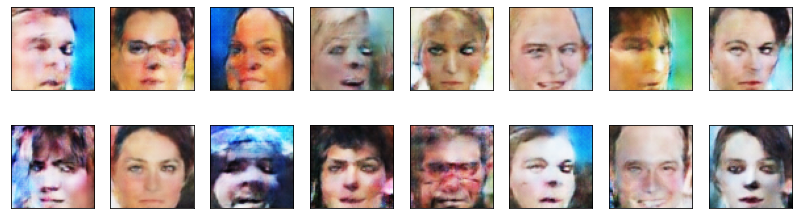

2024-05-10 12:23:43 | Epoch [11/20] | Batch 0/509 | d_loss: 0.7963 | g_loss: 0.8970
2024-05-10 12:23:50 | Epoch [11/20] | Batch 50/509 | d_loss: 0.8677 | g_loss: 1.3382
2024-05-10 12:23:57 | Epoch [11/20] | Batch 100/509 | d_loss: 0.6952 | g_loss: 3.0792
2024-05-10 12:24:03 | Epoch [11/20] | Batch 150/509 | d_loss: 0.6165 | g_loss: 1.5308
2024-05-10 12:24:10 | Epoch [11/20] | Batch 200/509 | d_loss: 0.5596 | g_loss: 1.2830
2024-05-10 12:24:17 | Epoch [11/20] | Batch 250/509 | d_loss: 0.9981 | g_loss: 2.7112
2024-05-10 12:24:23 | Epoch [11/20] | Batch 300/509 | d_loss: 1.1548 | g_loss: 3.8171
2024-05-10 12:24:30 | Epoch [11/20] | Batch 350/509 | d_loss: 0.8154 | g_loss: 0.4747
2024-05-10 12:24:37 | Epoch [11/20] | Batch 400/509 | d_loss: 0.7361 | g_loss: 1.9534
2024-05-10 12:24:43 | Epoch [11/20] | Batch 450/509 | d_loss: 0.9495 | g_loss: 1.9092
2024-05-10 12:24:50 | Epoch [11/20] | Batch 500/509 | d_loss: 0.5845 | g_loss: 2.4094


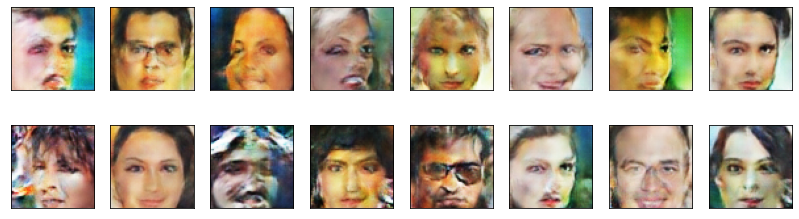

2024-05-10 12:24:56 | Epoch [12/20] | Batch 0/509 | d_loss: 0.8611 | g_loss: 1.7671
2024-05-10 12:25:03 | Epoch [12/20] | Batch 50/509 | d_loss: 0.6151 | g_loss: 2.0275
2024-05-10 12:25:10 | Epoch [12/20] | Batch 100/509 | d_loss: 0.7341 | g_loss: 1.6451
2024-05-10 12:25:16 | Epoch [12/20] | Batch 150/509 | d_loss: 0.8181 | g_loss: 1.7557
2024-05-10 12:25:23 | Epoch [12/20] | Batch 200/509 | d_loss: 0.7924 | g_loss: 2.4188
2024-05-10 12:25:30 | Epoch [12/20] | Batch 250/509 | d_loss: 0.9949 | g_loss: 1.7802
2024-05-10 12:25:36 | Epoch [12/20] | Batch 300/509 | d_loss: 0.8206 | g_loss: 1.9707
2024-05-10 12:25:43 | Epoch [12/20] | Batch 350/509 | d_loss: 0.7162 | g_loss: 0.6717
2024-05-10 12:25:50 | Epoch [12/20] | Batch 400/509 | d_loss: 0.7132 | g_loss: 0.8692
2024-05-10 12:25:56 | Epoch [12/20] | Batch 450/509 | d_loss: 0.6362 | g_loss: 1.6941
2024-05-10 12:26:03 | Epoch [12/20] | Batch 500/509 | d_loss: 0.8606 | g_loss: 2.0081


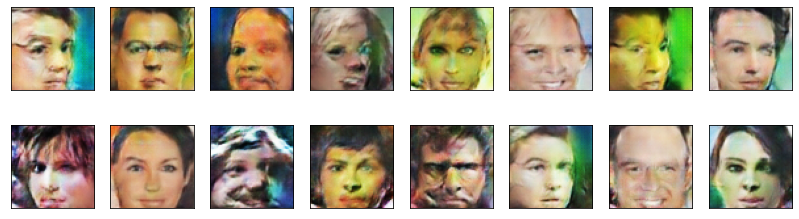

2024-05-10 12:26:09 | Epoch [13/20] | Batch 0/509 | d_loss: 0.5887 | g_loss: 1.9802
2024-05-10 12:26:16 | Epoch [13/20] | Batch 50/509 | d_loss: 0.6792 | g_loss: 2.3390
2024-05-10 12:26:22 | Epoch [13/20] | Batch 100/509 | d_loss: 0.6309 | g_loss: 1.2347
2024-05-10 12:26:29 | Epoch [13/20] | Batch 150/509 | d_loss: 0.6980 | g_loss: 2.5237
2024-05-10 12:26:36 | Epoch [13/20] | Batch 200/509 | d_loss: 0.8051 | g_loss: 2.0903
2024-05-10 12:26:42 | Epoch [13/20] | Batch 250/509 | d_loss: 0.7220 | g_loss: 2.2618
2024-05-10 12:26:49 | Epoch [13/20] | Batch 300/509 | d_loss: 1.2083 | g_loss: 3.4632
2024-05-10 12:26:56 | Epoch [13/20] | Batch 350/509 | d_loss: 0.5263 | g_loss: 2.9038
2024-05-10 12:27:02 | Epoch [13/20] | Batch 400/509 | d_loss: 0.7493 | g_loss: 1.8151
2024-05-10 12:27:09 | Epoch [13/20] | Batch 450/509 | d_loss: 0.6895 | g_loss: 1.4985
2024-05-10 12:27:16 | Epoch [13/20] | Batch 500/509 | d_loss: 0.9297 | g_loss: 1.0460


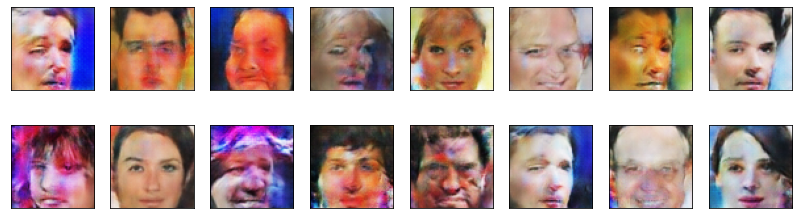

2024-05-10 12:27:20 | Epoch [14/20] | Batch 0/509 | d_loss: 0.6712 | g_loss: 2.4706
2024-05-10 12:27:26 | Epoch [14/20] | Batch 50/509 | d_loss: 1.1597 | g_loss: 5.5281
2024-05-10 12:27:33 | Epoch [14/20] | Batch 100/509 | d_loss: 0.4122 | g_loss: 1.9947
2024-05-10 12:27:40 | Epoch [14/20] | Batch 150/509 | d_loss: 1.0223 | g_loss: 1.4878
2024-05-10 12:27:46 | Epoch [14/20] | Batch 200/509 | d_loss: 0.5248 | g_loss: 1.1769
2024-05-10 12:27:53 | Epoch [14/20] | Batch 250/509 | d_loss: 0.9044 | g_loss: 2.6943
2024-05-10 12:28:00 | Epoch [14/20] | Batch 300/509 | d_loss: 0.5368 | g_loss: 1.7931
2024-05-10 12:28:06 | Epoch [14/20] | Batch 350/509 | d_loss: 0.8531 | g_loss: 2.2439
2024-05-10 12:28:13 | Epoch [14/20] | Batch 400/509 | d_loss: 0.5435 | g_loss: 1.7475
2024-05-10 12:28:20 | Epoch [14/20] | Batch 450/509 | d_loss: 0.6825 | g_loss: 3.9814
2024-05-10 12:28:26 | Epoch [14/20] | Batch 500/509 | d_loss: 0.6386 | g_loss: 1.6661


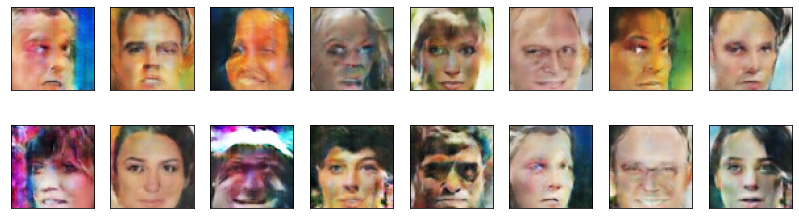

2024-05-10 12:28:32 | Epoch [15/20] | Batch 0/509 | d_loss: 0.6455 | g_loss: 1.7684
2024-05-10 12:28:39 | Epoch [15/20] | Batch 50/509 | d_loss: 0.8099 | g_loss: 2.4426
2024-05-10 12:28:45 | Epoch [15/20] | Batch 100/509 | d_loss: 0.5482 | g_loss: 1.9719
2024-05-10 12:28:52 | Epoch [15/20] | Batch 150/509 | d_loss: 0.7496 | g_loss: 1.9804
2024-05-10 12:28:59 | Epoch [15/20] | Batch 200/509 | d_loss: 0.6829 | g_loss: 1.7440
2024-05-10 12:29:06 | Epoch [15/20] | Batch 250/509 | d_loss: 1.4308 | g_loss: 1.1377
2024-05-10 12:29:12 | Epoch [15/20] | Batch 300/509 | d_loss: 1.1668 | g_loss: 0.9640
2024-05-10 12:29:19 | Epoch [15/20] | Batch 350/509 | d_loss: 0.7791 | g_loss: 2.0735
2024-05-10 12:29:26 | Epoch [15/20] | Batch 400/509 | d_loss: 0.5153 | g_loss: 1.9277
2024-05-10 12:29:32 | Epoch [15/20] | Batch 450/509 | d_loss: 0.5794 | g_loss: 3.2043
2024-05-10 12:29:39 | Epoch [15/20] | Batch 500/509 | d_loss: 1.6309 | g_loss: 5.0884


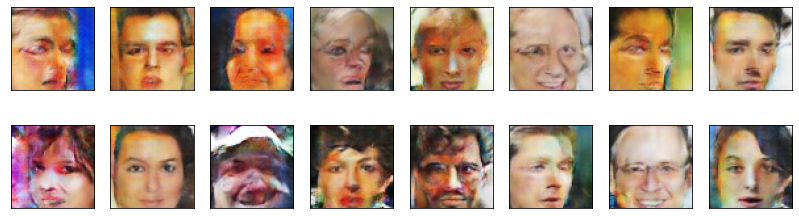

2024-05-10 12:29:44 | Epoch [16/20] | Batch 0/509 | d_loss: 0.5564 | g_loss: 2.1671
2024-05-10 12:29:51 | Epoch [16/20] | Batch 50/509 | d_loss: 0.7134 | g_loss: 2.0667
2024-05-10 12:29:58 | Epoch [16/20] | Batch 100/509 | d_loss: 0.6273 | g_loss: 1.6660
2024-05-10 12:30:04 | Epoch [16/20] | Batch 150/509 | d_loss: 0.8093 | g_loss: 2.9340
2024-05-10 12:30:11 | Epoch [16/20] | Batch 200/509 | d_loss: 0.4437 | g_loss: 1.3370
2024-05-10 12:30:18 | Epoch [16/20] | Batch 250/509 | d_loss: 0.5371 | g_loss: 2.0732
2024-05-10 12:30:24 | Epoch [16/20] | Batch 300/509 | d_loss: 1.4168 | g_loss: 3.7272
2024-05-10 12:30:31 | Epoch [16/20] | Batch 350/509 | d_loss: 0.4330 | g_loss: 1.1276
2024-05-10 12:30:38 | Epoch [16/20] | Batch 400/509 | d_loss: 0.8238 | g_loss: 2.7662
2024-05-10 12:30:44 | Epoch [16/20] | Batch 450/509 | d_loss: 0.3791 | g_loss: 0.8483
2024-05-10 12:30:51 | Epoch [16/20] | Batch 500/509 | d_loss: 0.4996 | g_loss: 2.1807


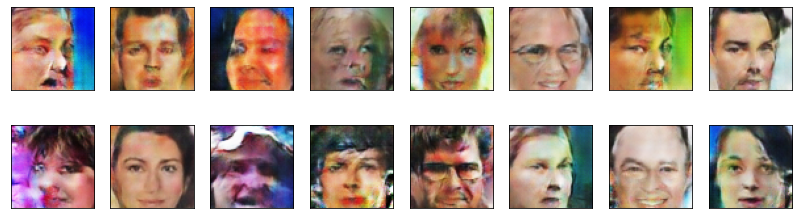

2024-05-10 12:30:57 | Epoch [17/20] | Batch 0/509 | d_loss: 0.4892 | g_loss: 2.7709
2024-05-10 12:31:04 | Epoch [17/20] | Batch 50/509 | d_loss: 0.6070 | g_loss: 3.4669
2024-05-10 12:31:11 | Epoch [17/20] | Batch 100/509 | d_loss: 0.7633 | g_loss: 2.5029
2024-05-10 12:31:17 | Epoch [17/20] | Batch 150/509 | d_loss: 0.8280 | g_loss: 2.6798
2024-05-10 12:31:24 | Epoch [17/20] | Batch 200/509 | d_loss: 0.3616 | g_loss: 1.2833
2024-05-10 12:31:31 | Epoch [17/20] | Batch 250/509 | d_loss: 0.5225 | g_loss: 2.7963
2024-05-10 12:31:37 | Epoch [17/20] | Batch 300/509 | d_loss: 0.9364 | g_loss: 1.2659
2024-05-10 12:31:44 | Epoch [17/20] | Batch 350/509 | d_loss: 0.6903 | g_loss: 2.8770
2024-05-10 12:31:51 | Epoch [17/20] | Batch 400/509 | d_loss: 0.6681 | g_loss: 2.2731
2024-05-10 12:31:57 | Epoch [17/20] | Batch 450/509 | d_loss: 1.2301 | g_loss: 3.0698
2024-05-10 12:32:04 | Epoch [17/20] | Batch 500/509 | d_loss: 0.5717 | g_loss: 1.5431


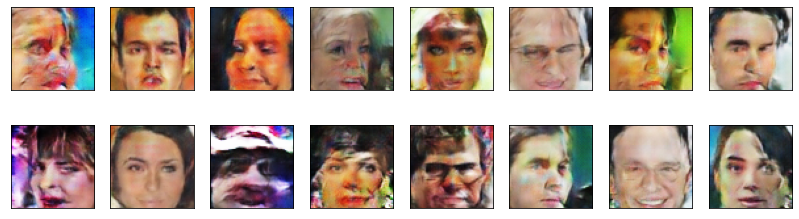

2024-05-10 12:32:08 | Epoch [18/20] | Batch 0/509 | d_loss: 0.3718 | g_loss: 2.0695
2024-05-10 12:32:15 | Epoch [18/20] | Batch 50/509 | d_loss: 0.5743 | g_loss: 2.7193
2024-05-10 12:32:22 | Epoch [18/20] | Batch 100/509 | d_loss: 0.3006 | g_loss: 2.6183
2024-05-10 12:32:29 | Epoch [18/20] | Batch 150/509 | d_loss: 1.4913 | g_loss: 0.3923
2024-05-10 12:32:35 | Epoch [18/20] | Batch 200/509 | d_loss: 1.6615 | g_loss: 1.0695
2024-05-10 12:32:42 | Epoch [18/20] | Batch 250/509 | d_loss: 0.7892 | g_loss: 1.3093
2024-05-10 12:32:49 | Epoch [18/20] | Batch 300/509 | d_loss: 0.7852 | g_loss: 1.3416
2024-05-10 12:32:55 | Epoch [18/20] | Batch 350/509 | d_loss: 0.4478 | g_loss: 2.0709
2024-05-10 12:33:02 | Epoch [18/20] | Batch 400/509 | d_loss: 0.3299 | g_loss: 2.5875
2024-05-10 12:33:09 | Epoch [18/20] | Batch 450/509 | d_loss: 0.4005 | g_loss: 2.1965
2024-05-10 12:33:15 | Epoch [18/20] | Batch 500/509 | d_loss: 1.4554 | g_loss: 4.4224


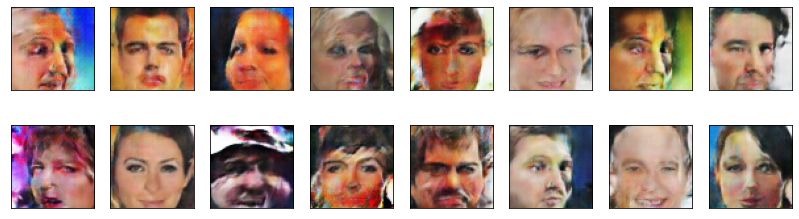

2024-05-10 12:33:21 | Epoch [19/20] | Batch 0/509 | d_loss: 0.4664 | g_loss: 2.3493
2024-05-10 12:33:28 | Epoch [19/20] | Batch 50/509 | d_loss: 0.7073 | g_loss: 1.4909
2024-05-10 12:33:34 | Epoch [19/20] | Batch 100/509 | d_loss: 0.9188 | g_loss: 5.6425
2024-05-10 12:33:41 | Epoch [19/20] | Batch 150/509 | d_loss: 0.4976 | g_loss: 4.1839
2024-05-10 12:33:48 | Epoch [19/20] | Batch 200/509 | d_loss: 0.3112 | g_loss: 3.1115
2024-05-10 12:33:54 | Epoch [19/20] | Batch 250/509 | d_loss: 0.6573 | g_loss: 4.3860
2024-05-10 12:34:01 | Epoch [19/20] | Batch 300/509 | d_loss: 0.7684 | g_loss: 1.8686
2024-05-10 12:34:08 | Epoch [19/20] | Batch 350/509 | d_loss: 0.2325 | g_loss: 3.1149
2024-05-10 12:34:14 | Epoch [19/20] | Batch 400/509 | d_loss: 0.1877 | g_loss: 2.8207
2024-05-10 12:34:21 | Epoch [19/20] | Batch 450/509 | d_loss: 0.6572 | g_loss: 3.0576
2024-05-10 12:34:28 | Epoch [19/20] | Batch 500/509 | d_loss: 0.5870 | g_loss: 1.2251


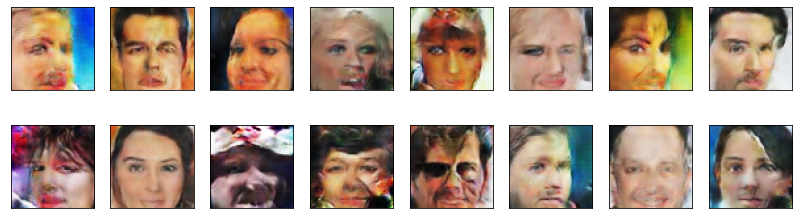

2024-05-10 12:34:33 | Epoch [20/20] | Batch 0/509 | d_loss: 0.4126 | g_loss: 3.1055
2024-05-10 12:34:39 | Epoch [20/20] | Batch 50/509 | d_loss: 0.6959 | g_loss: 4.1291
2024-05-10 12:34:46 | Epoch [20/20] | Batch 100/509 | d_loss: 0.8936 | g_loss: 1.3058
2024-05-10 12:34:53 | Epoch [20/20] | Batch 150/509 | d_loss: 1.0215 | g_loss: 1.1293
2024-05-10 12:34:59 | Epoch [20/20] | Batch 200/509 | d_loss: 2.0856 | g_loss: 1.5109
2024-05-10 12:35:06 | Epoch [20/20] | Batch 250/509 | d_loss: 1.3897 | g_loss: 6.8988
2024-05-10 12:35:13 | Epoch [20/20] | Batch 300/509 | d_loss: 0.3444 | g_loss: 2.8995
2024-05-10 12:35:20 | Epoch [20/20] | Batch 350/509 | d_loss: 0.2171 | g_loss: 3.5542
2024-05-10 12:35:27 | Epoch [20/20] | Batch 400/509 | d_loss: 0.3150 | g_loss: 3.0903
2024-05-10 12:35:33 | Epoch [20/20] | Batch 450/509 | d_loss: 0.3454 | g_loss: 3.9107
2024-05-10 12:35:40 | Epoch [20/20] | Batch 500/509 | d_loss: 0.6111 | g_loss: 0.6093


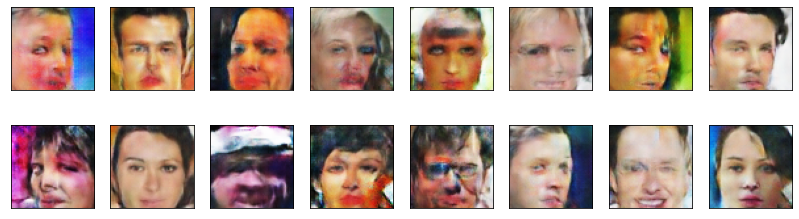

In [24]:
if train_on_gpu:
    fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()
else:
    fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float()
    
losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        
        if train_on_gpu:
            real_images = real_images.to(device)

        
        ####################################
        
        # TODO: implement the training strategy
        
        ####################################
        
        d_loss = discriminator_step(dataloader.batch_size,latent_dim,real_images,generator,discriminator)
        #d_loss = discriminator_step(dataloader.batch_size,latent_dim,real_images,generator,discriminator)

        g_loss = generator_step(dataloader.batch_size,latent_dim,generator,discriminator)
        g_loss = generator_step(dataloader.batch_size,latent_dim,generator,discriminator)
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss.item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

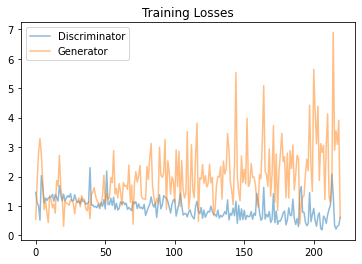

In [25]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** I a expecting the pictures to be more clear.  I believe adding more convolutions in the generator and discriminator may help add clarity as well as increasing the epochs.  So long as the processor (CPU or GPU) can handle a larger model and longer training time we should be able to produce clearer images. The optimizers are appropriate for this but adding LR scheduling may help improve the output.  Based off the graph and the research I did for loss functions and GANs  I

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.